In [1]:
%pylab inline
import galsim
import numpy as np
import astropy.io.fits as pyfits

import imgutil
import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/home/xiangchong/work/gw_ipmu/work/FPFS2/sim


+ corrections for ellipticity, response and flux ratio 

In [3]:
# Get the  galaxy generator      
# Load data
catName     =   'real_galaxy_catalog_25.2.fits'
directory   =   '../../galsim_train/COSMOS_25.2_training_sample/'
cosmos_cat  =   galsim.COSMOSCatalog(catName, dir=directory)

In [4]:
# PSF preparation
psfPre='psfPre'
# Basic parameters
ngrid       =   64
nrot        =   1
nx          =   1
ny          =   100000
ndata       =   nx*ny
scale       =   0.168
ngridTot    =   ngrid*nx
flux_scaling=   2.587

bigfft      =   galsim.GSParams(maximum_fft_size=10240)
# index
ifield=1
index_use   =   cosmos_cat.orig_index
# parametric catalog
param_cat   =   cosmos_cat.param_cat[index_use]
index       =   ifield%81400
record      =   param_cat[index]
# prepare the galaxies
gal0        =   cosmos_cat.makeGalaxy(gal_type='parametric',index=index,gsparams=bigfft)
gal0        *=  flux_scaling

# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
psfImg      =   galsim.fits.read(psfFname)
psfData=np.pad(psfImg.array,(11,10))
print(psfData.shape)

noiseHead   =   pyfits.getheader(psfFname)
psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
# Get the shear information
g1          =   noiseHead['g1']
g2          =   noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
#variance   =   noiseHead['var']
variance    =   noiseHead['var']
rescale     =   noiseHead['rescale']
ud          =   galsim.UniformDeviate(ifield*10000+1)
np.random.seed(ifield*10000+1)
final       =   galsim.Convolve([psfInt,gal0],gsparams=bigfft)

(64, 64)


In [5]:
# Noise
corPre='corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
corNoise    =   galsim.getCOSMOSNoise(file_name=corFname,rng=ud,cosmos_scale=scale,variance=variance)

corIn=pyfits.getdata(corFname)*variance
corIn=np.pad(corIn,(23,22))
corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones((ngrid,ngrid))))**2.)).real
corIn=corIn*corNum
powIn=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(corIn)).real)
powModel=np.zeros((1,ngrid,ngrid))
powModel[0]=powIn

(100000, 64, 64)


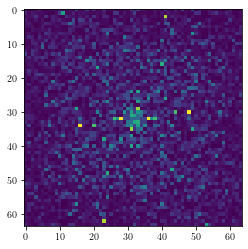

In [6]:
# original galaxy image
gal_image0   =   galsim.ImageF(ngrid,ngrid,scale=scale)
gal_image0.setOrigin(0,0)
final.drawImage(gal_image0,method='no_pixel')

# noisy galaxy image
gal_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image.setOrigin(0,0)
for i in range(ny):
    # Prepare the subimage
    ix      =   0
    iy      =   i
    b       =   galsim.BoundsI(ix*ngrid, (ix+1)*ngrid-1,iy*ngrid,(iy+1)*ngrid-1)
    sub_gal_image = gal_image[b]
    # Draw the galaxy image
    final.drawImage(sub_gal_image,method='no_pixel')

corNoise.applyTo(gal_image)
# image arrays
image_list=np.stack(np.vsplit(gal_image.array,ny))
print(image_list.shape)
galPow=imgutil.getFouPow(image_list[0])
subPow=imgutil.fitNoiPow(ngrid,galPow,np.ones((1,ngrid,ngrid)),26)
imshow(galPow-subPow)

In [7]:
fpTask=fpfsBase.fpfsTask(psfData)
a0=fpTask.measure(gal_image0.array)

## Correction Test

$\frac{x}{1+x}=x-x^2$

$\frac{y}{1+x}=y(1-x)$

$\frac{a}{1+x}=a(1-x+x^2)$

$\frac{a^2}{(1+x)^2}=a^2(1-2x+3x^2)$

$\frac{(a+y)^2}{(1+x)^2}=a^2(1-2x+3x^2)+y^2+2ay(1-2x)$

In [8]:
fpTask=fpfsBase.fpfsTask(psfData,noiModel=powModel)
a=fpTask.measure(image_list)

In [70]:
C=100
b0=fpfsBase.fpfsM2E(a0,C)
b=fpfsBase.fpfsM2E(a,C)

In [71]:
np.average(b['fpfs_e1'])

0.016227390199584652

In [72]:
np.average(b0['fpfs_e1']*(1+a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.)+a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)

0.01709060561562297

In [73]:
np.average(a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)

-0.0004656588222558009

In [74]:
np.average(b0['fpfs_e1'])

0.017046705844046547

In [75]:
np.average(b['fpfs_e2'])

-0.15628268523506286

In [76]:
np.average(b0['fpfs_e2']*(1+a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.)+a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)

-0.15453299486461017

In [77]:
np.average(b0['fpfs_e2'])

-0.15084097047755607

In [12]:
np.std(a['fpfs_M00'])

89.62017838696418

In [19]:
np.average(a['fpfs_M00'])

413.04817067745915

In [20]:
np.average(a['fpfs_N00N00']/(a['fpfs_M00']+10.)**2.)

0.00025691707187779983

In [21]:
a['fpfs_N00N00']

array([[47.4860798 ],
       [46.64808495],
       [48.40392253],
       ...,
       [48.12892569],
       [46.82195743],
       [47.91034925]])

In [22]:
a['fpfs_M00']

array([[425.15648451],
       [414.46556585],
       [418.56727003],
       ...,
       [410.70443361],
       [414.10608962],
       [423.2399518 ]])

In [23]:
a['fpfs_N00N22s']

array([[6.63734352],
       [5.59913578],
       [5.36546797],
       ...,
       [6.32196896],
       [5.77208809],
       [5.8449766 ]])

In [26]:
np.average(a['fpfs_N00N22s']/(a['fpfs_M00']+10.)**2.)

3.063994593348338e-05